In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import anndata2ri
import gdown
import scipy
import scipy.io
from rpy2.robjects import r

anndata2ri.activate()

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
    library(SeuratDisk)
})

# Expressions

## Download the data

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=1mXikpKDZ6Nqh42kDHHbwVeMJWc1V9mdB',
    'gayoso2020-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1mXikpKDZ6Nqh42kDHHbwVeMJWc1V9mdB
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/gayoso2020-expressions.h5ad
204MB [00:05, 38.8MB/s] 


'gayoso2020-expressions.h5ad'

In [5]:
adata = sc.read('gayoso2020-expressions.h5ad')
adata

AnnData object with n_obs × n_vars = 30293 × 4000
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_types_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [6]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_types']
adata_.obs['batch'] = adata.obs['batch_indices']

In [7]:
%%R -i adata_
rna = as.Seurat(adata_, counts='X', data=NULL)
rna

An object of class Seurat 
4000 features across 30293 samples within 1 assay 
Active assay: RNA (4000 features, 0 variable features)


# Protein

## Download the data

In [8]:
gdown.download(
    'https://drive.google.com/uc?id=1Y4wyzhaXrmW1anoByA5clmzrY6OurL4R',
    'gayoso2020-proteins.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1Y4wyzhaXrmW1anoByA5clmzrY6OurL4R
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/gayoso2020-proteins.h5ad
57.4MB [00:01, 39.5MB/s]


'gayoso2020-proteins.h5ad'

In [9]:
adata = sc.read('gayoso2020-proteins.h5ad')

In [10]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_types']
adata_.obs['batch'] = adata.obs['batch_indices']

In [11]:
%%R -i adata_
cite = as.Seurat(adata_, counts='X', data=NULL)
cite

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')



An object of class Seurat 
110 features across 30293 samples within 1 assay 
Active assay: RNA (110 features, 0 variable features)


# Integrate RNA batches

In [12]:
%%R
rna.list <- SplitObject(rna, split.by = "batch")
rna.list <- lapply(X = rna.list, FUN = SCTransform, variable.features.n = 4000)
features <- SelectIntegrationFeatures(object.list = rna.list, nfeatures = 4000)
rna.list <- PrepSCTIntegration(object.list = rna.list, anchor.features = features)

anchors <- FindIntegrationAnchors(object.list = rna.list, normalization.method = "SCT", 
    anchor.features = features)
integrated <- IntegrateData(anchorset = anchors, normalization.method = "SCT")

integrated <- RunPCA(integrated)

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3996 by 16845

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: Found 113 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3996 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3996 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 5.294546 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |============                                                          |  17%
  |                                                                            
  |=======================                                               |  33%
  |                                                                            
  |===================================                                   |  50%
  |                                                                         

  |======================================================================| 100%


R[write to console]: There are 1 estimated thetas smaller than 1e-07 - will be set to 1e-07

R[write to console]: Found 95 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3997 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3997 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 5.17424 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |============                                                          |  17%
  |                                                                            
  |=======================                                               |  33%
  |                                                                            
  |===================================                                   |  50%
  |                                                                          

  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~16s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=29s  


R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 31900 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 19749 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=13m 26s


R[write to console]: Merging dataset 2 into 1

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

# Integrate ADT batches

In [15]:
%%R
cite <- RenameAssays(cite, RNA='ADT')
cite

R[write to console]: Renaming default assay from RNA to ADT



An object of class Seurat 
110 features across 30293 samples within 1 assay 
Active assay: ADT (110 features, 0 variable features)


In [16]:
%%R
cite.list <- SplitObject(cite, split.by = "batch")

cite.list <- lapply(X = cite.list, FUN = function(x) {
    VariableFeatures(x) <- rownames(x[["ADT"]])
    x <- NormalizeData(x, normalization.method = 'CLR', margin = 2)
})

R[write to console]: Normalizing across cells



  |                                                  | 0 % ~calculating   |+                                                 | 0 % ~01m 58s       |+                                                 | 0 % ~01m 33s       |+                                                 | 0 % ~01m 35s       |+                                                 | 0 % ~01m 33s       |+                                                 | 0 % ~01m 34s       |+                                                 | 0 % ~01m 35s       |+                                                 | 0 % ~01m 48s       |+                                                 | 0 % ~01m 45s       |+                                                 | 0 % ~01m 43s       |+                                                 | 0 % ~01m 46s       |+                                                 | 0 % ~01m 43s       |+                                                 | 0 % ~01m 42s       |+                                                 | 0 % ~01m 

  |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 

  |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 37s       |+                                                 | 1 % ~01m 37s       |+                                                 | 1 % ~01m 37s       |+                                                 | 1 % ~01m 38s       |+                                                 | 1 % ~01m 37s       |+                                                 | 1 % ~01m 37s       |+                                                 | 1 % ~01m 37s       |+                                                 | 1 % ~01m 37s       |+                                                 | 1 % ~01m 37s       |+                                                 | 1 % ~01m 37s       |+                                                 | 1 % ~01m 37s       |+                                                 | 1 % ~01m 

  |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 36s       |++                                                | 2 % ~01m 

  |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 36s       |++                                                | 3 % ~01m 

  |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 35s       |++                                                | 3 % ~01m 

  |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 34s       |+++                                               | 4 % ~01m 

  |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 34s       |+++                                               | 5 % ~01m 

  |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 33s       |+++                                               | 5 % ~01m 

  |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 32s       |++++                                              | 6 % ~01m 

  |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 

  |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 7 % ~01m 31s       |++++                                              | 8 % ~01m 31s       |++++                                              | 8 % ~01m 31s       |++++                                              | 8 % ~01m 31s       |++++                                              | 8 % ~01m 

  |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 30s       |+++++                                             | 8 % ~01m 

  |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 

  |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 9 % ~01m 29s       |+++++                                             | 10% ~01m 29s       |+++++                                             | 10% ~01m 29s       |+++++                                             | 10% ~01m 29s       |+++++                                             | 10% ~01m 29s       |+++++                                             | 10% ~01m 29s       |+++++                                             | 10% ~01m 29s       |+++++                                             | 10% ~01m 29s       |+++++                                             | 10% ~01m 29s       |+++++                                             | 10% ~01m 

  |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 28s       |++++++                                            | 10% ~01m 

  |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 28s       |++++++                                            | 11% ~01m 

  |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 27s       |++++++                                            | 12% ~01m 

  |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 26s       |+++++++                                           | 12% ~01m 

  |+++++++                                           | 13% ~01m 26s       |+++++++                                           | 13% ~01m 26s       |+++++++                                           | 13% ~01m 26s       |+++++++                                           | 13% ~01m 26s       |+++++++                                           | 13% ~01m 26s       |+++++++                                           | 13% ~01m 26s       |+++++++                                           | 13% ~01m 26s       |+++++++                                           | 13% ~01m 25s       |+++++++                                           | 13% ~01m 25s       |+++++++                                           | 13% ~01m 25s       |+++++++                                           | 13% ~01m 25s       |+++++++                                           | 13% ~01m 25s       |+++++++                                           | 13% ~01m 25s       |+++++++                                           | 13% ~01m 

  |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 25s       |+++++++                                           | 14% ~01m 

  |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 24s       |++++++++                                          | 14% ~01m 

  |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 23s       |++++++++                                          | 15% ~01m 

  |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 23s       |++++++++                                          | 16% ~01m 

  |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 22s       |+++++++++                                         | 16% ~01m 

  |+++++++++                                         | 17% ~01m 22s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 21s       |+++++++++                                         | 17% ~01m 

  |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 21s       |+++++++++                                         | 18% ~01m 

  |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 20s       |++++++++++                                        | 18% ~01m 

  |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 20s       |++++++++++                                        | 19% ~01m 19s       |++++++++++                                        | 19% ~01m 

  |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 19s       |++++++++++                                        | 20% ~01m 

  |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 18s       |+++++++++++                                       | 20% ~01m 

  |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 18s       |+++++++++++                                       | 21% ~01m 

  |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 17s       |+++++++++++                                       | 22% ~01m 

  |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 16s       |++++++++++++                                      | 22% ~01m 

  |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 16s       |++++++++++++                                      | 23% ~01m 

  |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 15s       |++++++++++++                                      | 24% ~01m 

  |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 14s       |+++++++++++++                                     | 24% ~01m 

  |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 14s       |+++++++++++++                                     | 25% ~01m 

  |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 13s       |+++++++++++++                                     | 26% ~01m 

  |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 12s       |++++++++++++++                                    | 26% ~01m 

  |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 12s       |++++++++++++++                                    | 27% ~01m 

  |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 11s       |++++++++++++++                                    | 28% ~01m 

  |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 28% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 

  |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 10s       |+++++++++++++++                                   | 29% ~01m 

  |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 09s       |+++++++++++++++                                   | 30% ~01m 

  |++++++++++++++++                                  | 30% ~01m 08s       |++++++++++++++++                                  | 30% ~01m 08s       |++++++++++++++++                                  | 30% ~01m 08s       |++++++++++++++++                                  | 30% ~01m 08s       |++++++++++++++++                                  | 30% ~01m 08s       |++++++++++++++++                                  | 30% ~01m 08s       |++++++++++++++++                                  | 30% ~01m 08s       |++++++++++++++++                                  | 30% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 

  |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 08s       |++++++++++++++++                                  | 31% ~01m 

  |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 07s       |++++++++++++++++                                  | 32% ~01m 

  |+++++++++++++++++                                 | 32% ~01m 06s       |+++++++++++++++++                                 | 32% ~01m 06s       |+++++++++++++++++                                 | 32% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 

  |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 06s       |+++++++++++++++++                                 | 33% ~01m 

  |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 05s       |+++++++++++++++++                                 | 34% ~01m 

  |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 

  |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 04s       |++++++++++++++++++                                | 35% ~01m 

  |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 03s       |++++++++++++++++++                                | 36% ~01m 

  |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 

  |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 02s       |+++++++++++++++++++                               | 37% ~01m 

  |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 01s       |+++++++++++++++++++                               | 38% ~01m 

  |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 00s       |++++++++++++++++++++                              | 39% ~01m 

  |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s           |++++++++++++++++++++                              | 39% ~60s 

  |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |++++++++++++++++++++                              | 40% ~59s           |+++++++++++++++++++++                             | 40% ~59s 

  |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s 

  |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s           |+++++++++++++++++++++                             | 41% ~58s 

  |+++++++++++++++++++++                             | 42% ~57s           |+++++++++++++++++++++                             | 42% ~57s           |+++++++++++++++++++++                             | 42% ~57s           |+++++++++++++++++++++                             | 42% ~57s           |+++++++++++++++++++++                             | 42% ~57s           |+++++++++++++++++++++                             | 42% ~57s           |+++++++++++++++++++++                             | 42% ~57s           |++++++++++++++++++++++                            | 42% ~57s           |++++++++++++++++++++++                            | 42% ~57s           |++++++++++++++++++++++                            | 42% ~57s           |++++++++++++++++++++++                            | 42% ~57s           |++++++++++++++++++++++                            | 42% ~57s           |++++++++++++++++++++++                            | 42% ~57s           |++++++++++++++++++++++                            | 42% ~57s 

  |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s 

  |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s           |++++++++++++++++++++++                            | 43% ~56s 

  |++++++++++++++++++++++                            | 44% ~55s           |++++++++++++++++++++++                            | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s           |+++++++++++++++++++++++                           | 44% ~55s 

  |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s 

  |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s           |+++++++++++++++++++++++                           | 45% ~54s 

  |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s           |++++++++++++++++++++++++                          | 46% ~53s 

  |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s 

  |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s           |++++++++++++++++++++++++                          | 47% ~52s 

  |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s           |+++++++++++++++++++++++++                         | 48% ~51s 

  |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s 

  |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s           |+++++++++++++++++++++++++                         | 49% ~50s 

  |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s           |++++++++++++++++++++++++++                        | 50% ~49s 

  |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s 

  |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 51% ~48s           |++++++++++++++++++++++++++                        | 52% ~48s           |++++++++++++++++++++++++++                        | 52% ~48s 

  |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s           |+++++++++++++++++++++++++++                       | 52% ~47s 

  |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s 

  |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 53% ~46s           |+++++++++++++++++++++++++++                       | 54% ~46s           |+++++++++++++++++++++++++++                       | 54% ~46s           |+++++++++++++++++++++++++++                       | 54% ~46s           |+++++++++++++++++++++++++++                       | 54% ~46s           |+++++++++++++++++++++++++++                       | 54% ~46s           |+++++++++++++++++++++++++++                       | 54% ~46s           |+++++++++++++++++++++++++++                       | 54% ~46s 

  |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s           |++++++++++++++++++++++++++++                      | 54% ~45s 

  |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 55% ~44s 

  |++++++++++++++++++++++++++++                      | 55% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s           |++++++++++++++++++++++++++++                      | 56% ~44s 

  |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s           |+++++++++++++++++++++++++++++                     | 56% ~43s 

  |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s           |+++++++++++++++++++++++++++++                     | 57% ~42s 

  |+++++++++++++++++++++++++++++                     | 58% ~42s           |+++++++++++++++++++++++++++++                     | 58% ~42s           |+++++++++++++++++++++++++++++                     | 58% ~42s           |+++++++++++++++++++++++++++++                     | 58% ~42s           |+++++++++++++++++++++++++++++                     | 58% ~42s           |+++++++++++++++++++++++++++++                     | 58% ~42s           |+++++++++++++++++++++++++++++                     | 58% ~42s           |+++++++++++++++++++++++++++++                     | 58% ~42s           |+++++++++++++++++++++++++++++                     | 58% ~42s           |+++++++++++++++++++++++++++++                     | 58% ~42s           |+++++++++++++++++++++++++++++                     |  |+++++++++++++++++++++++++++++++                   | 61% ~38s           |+++++++++++++++++++++++++++++++                   | 62% ~38s           |+++++++++++++++++++++++++++++++                   | 62% ~38s           |+++++++

 62% ~37s           |++++++++++++++++++++++++++++++++                  | 62% ~37s           |++++++++++++++++++++++++++++++++                  | 62% ~37s           |++++++++++++++++++++++++++++++++                  | 62% ~37s           |++++++++++++++++++++++++++++++++                  | 62% ~37s           |++++++++++++++++++++++++++++++++                  | 62% ~37s           |++++++++++++++++++++++++++++++++                  | 63% ~37s           |++++++++++++++++++++++++++++++++                  | 63% ~37s           |++++++++++++++++++++++++++++++++                  | 63% ~37s           |++++++++++++++++++++++++++++++++                  | 63% ~37s           |++++++++++++++++++++++++++++++++                  | 63% ~37s           |++++++++++++++++++++++++++++++++                  | 63% ~37s           |++++++++++++++++++++++++++++++++                  | 63% ~37s           |++++++++++++++++++++++++++++++++                  | 63% ~37s           |++++++++++++++++++++++++++++++++           

 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++                  | 64% ~36s           |++++++++++++++++++++++++++++++++           

 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++                 | 65% ~35s           |+++++++++++++++++++++++++++++++++          

  |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s           |+++++++++++++++++++++++++++++++++                 | 66% ~34s 

  |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s           |++++++++++++++++++++++++++++++++++                | 66% ~33s 

  |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s           |++++++++++++++++++++++++++++++++++                | 67% ~32s 

  |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s           |++++++++++++++++++++++++++++++++++                | 68% ~32s 

  |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s           |+++++++++++++++++++++++++++++++++++               | 68% ~31s 

  |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s           |+++++++++++++++++++++++++++++++++++               | 69% ~30s 

  |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s           |+++++++++++++++++++++++++++++++++++               | 70% ~30s 

  |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s           |++++++++++++++++++++++++++++++++++++              | 70% ~29s 

  |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s           |++++++++++++++++++++++++++++++++++++              | 71% ~28s 

  |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s           |++++++++++++++++++++++++++++++++++++              | 72% ~28s 

  |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s           |+++++++++++++++++++++++++++++++++++++             | 72% ~27s 

 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~22s           |+++++++++++++++++++++++++++++++++++++++    

 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~21s           |++++++++++++++++++++++++++++++++++++++++   

 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~21s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~20s           |++++++++++++++++++++++++++++++++++++++++   

 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~20s           |++++++++++++++++++++++++++++++++++++++++   

 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 80% ~19s           |+++++++++++++++++++++++++++++++++++++++++  

 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++         | 81% ~19s           |+++++++++++++++++++++++++++++++++++++++++  

 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~18s           |+++++++++++++++++++++++++++++++++++++++++  

 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~17s           |++++++++++++++++++++++++++++++++++++++++++ 

 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~17s           |++++++++++++++++++++++++++++++++++++++++++ 

 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~16s           |++++++++++++++++++++++++++++++++++++++++++ 

 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~15s           |+++++++++++++++++++++++++++++++++++++++++++

 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~15s           |+++++++++++++++++++++++++++++++++++++++++++

  |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~11s 

 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~09s           |+++++++++++++++++++++++++++++++++++++++++++

 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~08s           |+++++++++++++++++++++++++++++++++++++++++++

 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~07s           |+++++++++++++++++++++++++++++++++++++++++++

 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++

 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 94% ~06s           |+++++++++++++++++++++++++++++++++++++++++++

 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~05s           |+++++++++++++++++++++++++++++++++++++++++++

 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++

 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~04s           |+++++++++++++++++++++++++++++++++++++++++++

 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~03s           |+++++++++++++++++++++++++++++++++++++++++++

 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++

 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~02s           |+++++++++++++++++++++++++++++++++++++++++++

 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |+++++++++++++++++++++++++++++++++++++++++++

 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                               | 5 % ~01m 14s       |+++                                        

 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                              | 6 % ~01m 13s       |++++                                       

 7 % ~01m 13s       |++++                                              | 7 % ~01m 13s       |++++                                              | 7 % ~01m 13s       |++++                                              | 7 % ~01m 13s       |++++                                              | 7 % ~01m 13s       |++++                                              | 7 % ~01m 13s       |++++                                              | 7 % ~01m 13s       |++++                                              | 7 % ~01m 13s       |++++                                              | 7 % ~01m 13s       |++++                                              | 7 % ~01m 12s       |++++                                              | 7 % ~01m 12s       |++++                                              | 7 % ~01m 12s       |++++                                              | 7 % ~01m 12s       |++++                                              | 7 % ~01m 12s       |++++                                       

 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                              | 8 % ~01m 12s       |++++                                       

 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                             | 9 % ~01m 12s       |+++++                                      

 9 % ~01m 11s       |+++++                                             | 9 % ~01m 11s       |+++++                                             | 9 % ~01m 11s       |+++++                                             | 9 % ~01m 11s       |+++++                                             | 9 % ~01m 11s       |+++++                                             | 9 % ~01m 11s       |+++++                                             | 10% ~01m 11s       |+++++                                             | 10% ~01m 11s       |+++++                                             | 10% ~01m 11s       |+++++                                             | 10% ~01m 11s       |+++++                                             | 10% ~01m 11s       |+++++                                             | 10% ~01m 11s       |+++++                                             | 10% ~01m 11s       |+++++                                             | 10% ~01m 11s       |+++++                                      

 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                            | 10% ~01m 10s       |++++++                                     

 11% ~01m 10s       |++++++                                            | 11% ~01m 10s       |++++++                                            | 11% ~01m 10s       |++++++                                            | 11% ~01m 10s       |++++++                                            | 11% ~01m 10s       |++++++                                            | 11% ~01m 10s       |++++++                                            | 11% ~01m 10s       |++++++                                            | 11% ~01m 09s       |++++++                                            | 11% ~01m 09s       |++++++                                            | 11% ~01m 09s       |++++++                                            | 11% ~01m 09s       |++++++                                            | 11% ~01m 09s       |++++++                                            | 11% ~01m 09s       |++++++                                            | 11% ~01m 09s       |++++++                                     

 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                           | 12% ~01m 09s       |+++++++                                    

 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                           | 13% ~01m 08s       |+++++++                                    

 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                           | 14% ~01m 07s       |+++++++                                    

 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                        | 20% ~01m 02s       |++++++++++                                 

  |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 00s       |++++++++++++                                      | 22% ~01m 

  |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s           |++++++++++++++                                    | 26% ~57s 

  |+++++++++++++++++                                 | 32% ~53s           |+++++++++++++++++                                 | 32% ~53s           |+++++++++++++++++                                 | 32% ~53s           |+++++++++++++++++                                 | 32% ~53s           |+++++++++++++++++                                 | 32% ~53s           |+++++++++++++++++                                 | 32% ~53s           |+++++++++++++++++                                 | 32% ~53s           |+++++++++++++++++                                 | 32% ~53s           |+++++++++++++++++                                 | 32% ~53s           |+++++++++++++++++                                 | 33% ~53s           |+++++++++++++++++                                 | 33% ~53s           |+++++++++++++++++                                 | 33% ~53s           |+++++++++++++++++                                 | 33% ~53s           |+++++++++++++++++                                 | 33% ~53s 

  |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s           |+++++++++++++++++                                 | 33% ~52s 

  |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s           |++++++++++++++++++                                | 34% ~51s 

  |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s           |++++++++++++++++++                                | 35% ~51s 

  |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s           |++++++++++++++++++                                | 36% ~50s 

  |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s           |+++++++++++++++++++                               | 37% ~49s 

  |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s           |+++++++++++++++++++                               | 38% ~49s 

  |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s           |++++++++++++++++++++                              | 38% ~48s 

  |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s           |++++++++++++++++++++                              | 39% ~47s 

 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                           | 46% ~42s           |+++++++++++++++++++++++                    

 46% ~42s           |++++++++++++++++++++++++                          | 46% ~42s           |++++++++++++++++++++++++                          | 46% ~42s           |++++++++++++++++++++++++                          | 46% ~42s           |++++++++++++++++++++++++                          | 46% ~42s           |++++++++++++++++++++++++                          | 46% ~42s           |++++++++++++++++++++++++                          | 46% ~42s           |++++++++++++++++++++++++                          | 46% ~42s           |++++++++++++++++++++++++                          | 47% ~42s           |++++++++++++++++++++++++                          | 47% ~42s           |++++++++++++++++++++++++                          | 47% ~42s           |++++++++++++++++++++++++                          | 47% ~42s           |++++++++++++++++++++++++                          | 47% ~42s           |++++++++++++++++++++++++                          | 47% ~42s           |++++++++++++++++++++++++                   

 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                          | 47% ~41s           |++++++++++++++++++++++++                   

 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                         | 48% ~40s           |+++++++++++++++++++++++++                  

 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                         | 49% ~40s           |+++++++++++++++++++++++++                  

 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                         | 50% ~39s           |+++++++++++++++++++++++++                  

 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                        | 51% ~38s           |++++++++++++++++++++++++++                 

 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                        | 52% ~38s           |++++++++++++++++++++++++++                 

 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                       | 52% ~37s           |+++++++++++++++++++++++++++                

 53% ~36s           |+++++++++++++++++++++++++++                       | 53% ~36s           |+++++++++++++++++++++++++++                       |  |+++++++++++++++++++++++++++++                     | 57% ~33s           |+++++++++++++++++++++++++++++                     | 57% ~33s           |+++++++++++++++++++++++++++++                     | 57% ~33s           |+++++++++++++++++++++++++++++                     | 58% ~33s           |+++++++++++++++++++++++++++++                     | 58% ~33s           |+++++++++++++++++++++++++++++                     | 58% ~33s           |+++++++++++++++++++++++++++++                     | 58% ~33s           |+++++++++++++++++++++++++++++                     | 58% ~33s           |+++++++++++++++++++++++++++++                     | 58% ~33s           |+++++++++++++++++++++++++++++                     | 58% ~33s           |+++++++++++++++++++++++++++++                     | 58% ~33s           |+++++++++++++++++++++++++++++                     | 58% ~33s 

 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++                    | 59% ~32s           |++++++++++++++++++++++++++++++             

  |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s           |+++++++++++++++++++++++++++++++                   | 60% ~31s 

 61% ~30s           |+++++++++++++++++++++++++++++++                   | 61% ~30s           |+++++++++++++++++++++++++++++++                   | 61% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++                   | 62% ~30s           |+++++++++++++++++++++++++++++++            

 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++                  | 63% ~29s           |++++++++++++++++++++++++++++++++           

  |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s           |+++++++++++++++++++++++++++++++++                 | 64% ~28s 

 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++                 | 65% ~27s           |+++++++++++++++++++++++++++++++++          

  |++++++++++++++++++++++++++++++++++                | 67% ~26s           |++++++++++++++++++++++++++++++++++                | 67% ~26s           |++++++++++++++++++++++++++++++++++                | 67% ~26s           |++++++++++++++++++++++++++++++++++                | 67% ~26s           |+++++++++++++++++++++++++++++++++++               | 68% ~25s           |+++++++++++++++++++++++++++++++++++               | 68% ~25s           |+++++++++++++++++++++++++++++++++++               | 68% ~25s           |+++++++++++++++++++++++++++++++++++               | 68% ~25s           |+++++++++++++++++++++++++++++++++++               | 68% ~25s           |+++++++++++++++++++++++++++++++++++               | 68% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s 

  |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s           |+++++++++++++++++++++++++++++++++++               | 69% ~24s 

  |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s           |++++++++++++++++++++++++++++++++++++              | 70% ~23s 

  |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~23s           |++++++++++++++++++++++++++++++++++++              | 71% ~22s           |++++++++++++++++++++++++++++++++++++              | 71% ~22s 

  |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s           |++++++++++++++++++++++++++++++++++++              | 72% ~22s 

  |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s           |+++++++++++++++++++++++++++++++++++++             | 73% ~21s 

  |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s           |+++++++++++++++++++++++++++++++++++++             | 74% ~21s 

  |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s           |++++++++++++++++++++++++++++++++++++++            | 74% ~20s 

  |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s           |++++++++++++++++++++++++++++++++++++++            | 75% ~19s 

  |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~19s 

  |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~18s 

  |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~17s 

  |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~13s 

  |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~12s 

  |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~11s           |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~11s           |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~11s           |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~11s           |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~11s           |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~11s           |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~11s           |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~11s           87% ~10s           |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~10s           |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~10s           |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~10s           |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~10s           |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~10s           |++++++++++++++++++++++++++++++++++++++++++

  |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s           |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~09s 

 89% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~08s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~08s           |+++++++++++++++++++++++++++++++++++++++++++

 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~07s           |+++++++++++++++++++++++++++++++++++++++++++

  |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~06s 

  |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~05s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~05s 

  |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~04s 

  |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~02s 

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~01s 

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~01s 

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% ~00s          |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% ~00s          |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% ~00s          |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% ~00s          |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% ~00s          |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% ~00s          |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% ~00s          |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 18s


In [17]:
%%R
features <- SelectIntegrationFeatures(object.list = cite.list)

cite.list <- lapply(X = cite.list, FUN = function(x) {
    x <- ScaleData(x, features = features)
    x <- RunPCA(x, features = features, reduction.name = "pca")
})

R[write to console]: Centering and scaling data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: PC_ 1 
Positive:  ADT-CD90.2-A0075, ADT-CD43-A0110, ADT-CD5-A0111, ADT-TCRbchain-A0120, ADT-CD11a-A0595, ADT-CD73-A0077, ADT-CD278(ICOS)-A0171, ADT-CD357(GITR)-A0193, ADT-CD4-A0001, ADT-CD127(IL-7Ra)-A0198 
	   ADT-CD45-A0096, ADT-CD28-A0204, ADT-CD8b(Ly-3)-A0230, ADT-CD8a-A0002, ADT-CD86-A0200, ADT-CD62L-A0112, ADT-CD103-A0201, ADT-CD117(c-Kit)-A0012, ADT-Ly-6C-A0013, ADT-CD45.2-A0157 
	   ADT-CD183(CXCR3)-A0228, ADT-CD134(OX-40)-A0195, ADT-CD184(CXCR4)-A0444, ADT-CD122(IL-2Rb)-A0227, ADT-integrinb7-A0214, ADT-TCRVb8.1-8.2-A0235, ADT-CD304(Neuropilin-1)-A0552, ADT-TCRVb5.1

In [18]:
%%R
anchors <- FindIntegrationAnchors(object.list = cite.list, reduction = "rpca", 
    dims = 1:30)
integrated_adt <- IntegrateData(anchorset = anchors, dims = 1:30)

R[write to console]: Computing 2000 integration features

R[write to console]: Scaling features for provided objects



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


R[write to console]: Computing within dataset neighborhoods



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~13s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=23s  


R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 19649 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=32s  


R[write to console]: Merging dataset 2 into 1

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

In [19]:
%%R
integrated_adt <- ScaleData(integrated_adt)
integrated_adt <- RunPCA(integrated_adt, reduction.name = "apca")

R[write to console]: Centering and scaling data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: PC_ 1 
Positive:  ADT-CD90.2-A0075, ADT-CD43-A0110, ADT-CD5-A0111, ADT-TCRbchain-A0120, ADT-CD11a-A0595, ADT-CD73-A0077, ADT-CD278(ICOS)-A0171, ADT-CD357(GITR)-A0193, ADT-CD4-A0001, ADT-CD127(IL-7Ra)-A0198 
	   ADT-CD28-A0204, ADT-CD8b(Ly-3)-A0230, ADT-CD8a-A0002, ADT-CD45-A0096, ADT-CD86-A0200, ADT-CD103-A0201, ADT-CD117(c-Kit)-A0012, ADT-CD62L-A0112, ADT-Ly-6C-A0013, ADT-CD45.2-A0157 
	   ADT-CD183(CXCR3)-A0228, ADT-CD134(OX-40)-A0195, ADT-CD184(CXCR4)-A0444, ADT-integrinb7-A0214, ADT-CD122(IL-2Rb)-A0227, ADT-TCRVb5.1-5.2-A0354, ADT-CD304(Neuropilin-1)-A0552, ADT-TCRVb8.1

# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [20]:
%%R

integrated[["IADT"]] <- integrated_adt[["integrated"]]
integrated[["apca"]] <- integrated_adt[["apca"]]

integrated <- FindMultiModalNeighbors(integrated, reduction.list = list("pca", "apca"), 
                              dims.list = list(1:50, 1:30), modality.weight.name = "RNA.weight")

integrated <- RunSPCA(integrated, assay = 'integrated', graph = 'wsnn', npcs = 20)

SaveH5Seurat(integrated, 'gayoso-seurat.h5seurat', overwrite = TRUE)

R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~22s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=43s  


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~05s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=11s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~01m 09s       |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02m 26s
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~16s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=25s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Computing sPCA transformation

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA

R[write to console]: Adding counts for SCT

R[write to console]: Adding data for SCT

R[write to console]: Adding scale.data for SCT

R[write to console]: No variable features found for SCT

R[write to console]: No feature-level metadata found for SCT

R[write to console]: Writing out SCTModel.list for SCT

R[write to console]: Adding data for integrated

R[write to console]: Adding scale.data for integrated

R[write to console]: Adding variable features for integrated

R[write to console]: No feature-level metadata found for integrated

R[write to console]

In [36]:
%%R
integrated[["apca"]] <- NULL

In [37]:
%%R
SaveH5Seurat(integrated, 'gayoso-seurat.h5seurat', overwrite = TRUE)

R[write to console]: Warning:
R[write to console]:  Overwriting previous file gayoso-seurat.h5seurat

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA

R[write to console]: Adding counts for SCT

R[write to console]: Adding data for SCT

R[write to console]: Adding scale.data for SCT

R[write to console]: No variable features found for SCT

R[write to console]: No feature-level metadata found for SCT

R[write to console]: Writing out SCTModel.list for SCT

R[write to console]: Adding data for integrated

R[write to console]: Adding scale.data for integrated

R[write to console]: Adding variable features for integrated

R[write to console]: No feature-level metadata found for integrated

R[write to console]: Writing out SCTModel.list for integrated

R[write to console

In [38]:
%%R
Convert("gayoso-seurat.h5seurat", assay="integrated", "gayoso-seurat.h5ad", overwrite=TRUE)

R[write to console]: Validating h5Seurat file

R[write to console]: Adding scale.data from integrated as X

R[write to console]: Adding data from integrated as raw

R[write to console]: Transfering meta.data to obs

R[write to console]: Adding dimensional reduction information for pca

R[write to console]: Adding feature loadings for pca

R[write to console]: Adding dimensional reduction information for spca

R[write to console]: Adding feature loadings for spca

R[write to console]: Adding wsnn as neighbors

R[write to console]: Adding scale.data from SCT as a layer



In [39]:
integrated = sc.read('gayoso-seurat.h5ad')
integrated

AnnData object with n_obs × n_vars = 30293 × 3994
    obs: 'cell_type', 'batch', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'integrated.weight'
    var: 'features', 'SCT_features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_spca'
    varm: 'PCs', 'SPCA'
    layers: 'SCT'
    obsp: 'distances'

In [40]:
latent = sc.AnnData(integrated.obsm['X_spca'])
latent.obs = integrated.obs
latent.obsp['connectivities'] = integrated.uns['neighbors']['distances']

In [41]:
latent.write('../data/integrated/seurat/gayoso-seurat.h5ad')

... storing 'cell_type' as categorical


In [43]:
!rm 'gayoso2020-expressions.h5ad'
!rm 'gayoso2020-proteins.h5ad'
!rm 'gayoso-seurat.h5ad'
!rm 'gayoso-seurat.h5seurat'

In [44]:
%%R
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /mnt/home/icb/anastasia.litinetskaya/miniconda3/envs/signac/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Matrix_1.3-2                SeuratDisk_0.0.0.9018      
 [3] SeuratObject_4.0.0          Seurat_4.0.0               
 [5] SingleCellExperiment_1.12.0 SummarizedExperiment_1.20.0
 [7] Biobase_2.50.0              GenomicRanges_1.42.0     

# Visualize results

In [45]:
sc.pp.neighbors(latent)
sc.tl.umap(latent)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  ada

In [48]:
latent.obs.batch = latent.obs.batch.astype('category')

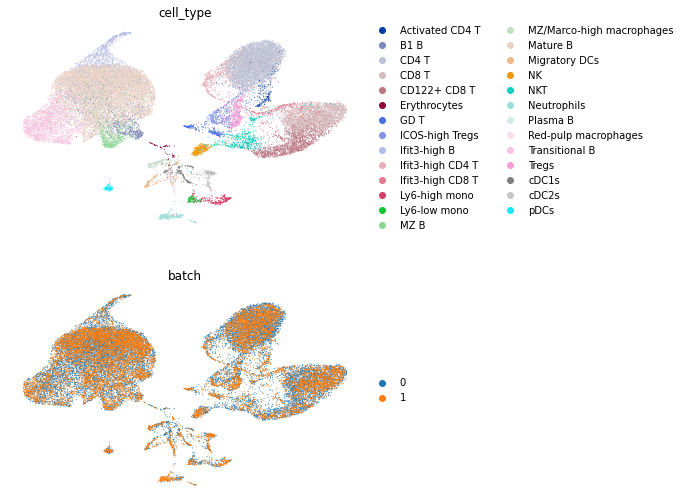

In [49]:
sc.pl.umap(latent, color=['cell_type', 'batch'], ncols=1, frameon=False)